<img src="https://cdn.datamaker.io/datamaker-erp/media/uploads/2020/09/22/resnet_34_layer.png" width="500px">

- **Reference**
    - https://www.datamaker.io/blog/posts/36
    - https://github.com/MyungKyuYi/AI-class/blob/main/Variants_of_CNN
    - https://velog.io/@lighthouse97/ResNet%EC%9D%98-%EC%9D%B4%ED%95%B4
    
ResNet(Residual Network)은 CNN의 주요 모델 중 하나로, VGGNet의 연구를 바탕으로 개발되었다. VGGNet에서는 깊이가 성능에 긍정적인 영향을 미치는 것을 확인했지만, 깊이를 무작정 늘리면 학습이 어려워지는 문제점이 있다. 이러한 문제는 두 가지로, 첫째, Gradient Vanishing/Exploding 현상으로 인해 네트워크가 깊어질수록 기울기 값이 너무 작거나 커져 학습 속도가 느려질 수 있으며, 둘째, Overfitting 현상으로 인해 깊어짐에 따라 파라미터 수가 증가해 과적합의 위험이 커진다. 

ResNet 개발팀은 VGG의 19층 연구를 넘어서 100층 이상의 모델을 실험했으나, 층이 깊어질수록 에러율이 증가하는 결과를 얻었다. 이들은 깊이에 따른 학습 효율을 높이기 위해 Residual Learning 방식을 도입하였다. Residual Learning은 기존의 신경망 구조와 달리 i번째 층과 (i+r)층을 연결하여 정보가 한 층을 건너뛰게 하며, 이를 통해 기울기가 쉽게 전파될 수 있다. Shortcut Connection을 사용하여 기존 방식은 입력값 x를 받아 H(x)를 출력하는 반면, Residual Learning은 목표치를 H(x) 대신 F(x) + x로 설정하여 H(x) = F(x) + x의 형태로 표현한다. 이 과정은 Identity Mapping으로 정의되며, 추가적인 파라미터가 필요 없다. 

ResNet은 VGG의 구조와 유사하게 설계되었으며, 합성곱 층을 추가하고 shortcut connection을 도입하여 깊이를 늘린다. 이러한 구조는 발전을 거듭해 19층에서 256층까지 확장되었다.

In [68]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import skew
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import numpy as np
import scipy
from tqdm import tqdm

In [69]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from keras.utils import to_categorical

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D


---

In [70]:
# data load

df = pd.read_csv("../../data/PAMAP/PAMAP_features.csv")
df

Unnamed: 0  sub_id  ...  ankle_gyr_yz_cor ankle_gyr_xz_cor
0            3006       2  ...         -0.003001        -0.638866
1            3497       2  ...         -0.654575         0.391363
2           14495       7  ...         -0.528138         0.402147
3           13278       7  ...          0.237828        -0.729771
4           14969       8  ...          0.066954         0.057685
...           ...     ...  ...               ...              ...
11768       10708       6  ...         -0.000800         0.031654
11769        4870       3  ...         -0.076216         0.009411
11770       11822       6  ...         -0.442849         0.063207
11771        3866       2  ...         -0.627185         0.436639
11772        3450       2  ...         -0.662742        -0.085954

[11773 rows x 68 columns]

In [71]:
# 각 feature의 이름
# https://archive.ics.uci.edu/ml/machine-learning-databases/00231/readme.pdf

features_name = {0: 'transient', 1:'lying', 2:'sitting', 3:'standing',
              4:'walking', 5:'running', 6:'cycling', 7:'Nordic walking',
              9:'watching TV', 10:'computer work', 11:'car driving',
              12:'ascending stairs', 13:'descending stairs', 16:'vacuum cleaning',
              17:'ironing', 18:'folding laundry', 19:'house cleaning',
              20:'playing soccer', 24:'rope jumping'}

print (features_name)
print ()
df.info()

{0: 'transient', 1: 'lying', 2: 'sitting', 3: 'standing', 4: 'walking', 5: 'running', 6: 'cycling', 7: 'Nordic walking', 9: 'watching TV', 10: 'computer work', 11: 'car driving', 12: 'ascending stairs', 13: 'descending stairs', 16: 'vacuum cleaning', 17: 'ironing', 18: 'folding laundry', 19: 'house cleaning', 20: 'playing soccer', 24: 'rope jumping'}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11773 entries, 0 to 11772
Data columns (total 68 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        11773 non-null  int64  
 1   sub_id            11773 non-null  int64  
 2   activity_id       11773 non-null  int64  
 3   act_level         11773 non-null  object 
 4   hr_mean           11773 non-null  float64
 5   hr_mean_normal    11773 non-null  float64
 6   hr_std            11773 non-null  float64
 7   hr_std_normal     11773 non-null  float64
 8   hand_tmp_mean     11773 non-null  float64
 9   hand_tmp_std   

In [72]:
# 결측치 제거

print (df.isnull().sum())

df = df.dropna()

print (df.isnull().sum())

Unnamed: 0          0
sub_id              0
activity_id         0
act_level           0
hr_mean             0
                   ..
chest_gyr_yz_cor    0
chest_gyr_xz_cor    0
ankle_gyr_xy_cor    0
ankle_gyr_yz_cor    0
ankle_gyr_xz_cor    0
Length: 68, dtype: int64
Unnamed: 0          0
sub_id              0
activity_id         0
act_level           0
hr_mean             0
                   ..
chest_gyr_yz_cor    0
chest_gyr_xz_cor    0
ankle_gyr_xy_cor    0
ankle_gyr_yz_cor    0
ankle_gyr_xz_cor    0
Length: 68, dtype: int64


In [73]:
# label encoding

from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
df['activity_id'] = LE.fit_transform(df['activity_id'])
df['act_level'] = LE.fit_transform(df['act_level'])

df

Unnamed: 0  sub_id  ...  ankle_gyr_yz_cor  ankle_gyr_xz_cor
0            3006       2  ...         -0.003001         -0.638866
1            3497       2  ...         -0.654575          0.391363
2           14495       7  ...         -0.528138          0.402147
3           13278       7  ...          0.237828         -0.729771
4           14969       8  ...          0.066954          0.057685
...           ...     ...  ...               ...               ...
11768       10708       6  ...         -0.000800          0.031654
11769        4870       3  ...         -0.076216          0.009411
11770       11822       6  ...         -0.442849          0.063207
11771        3866       2  ...         -0.627185          0.436639
11772        3450       2  ...         -0.662742         -0.085954

[11773 rows x 68 columns]

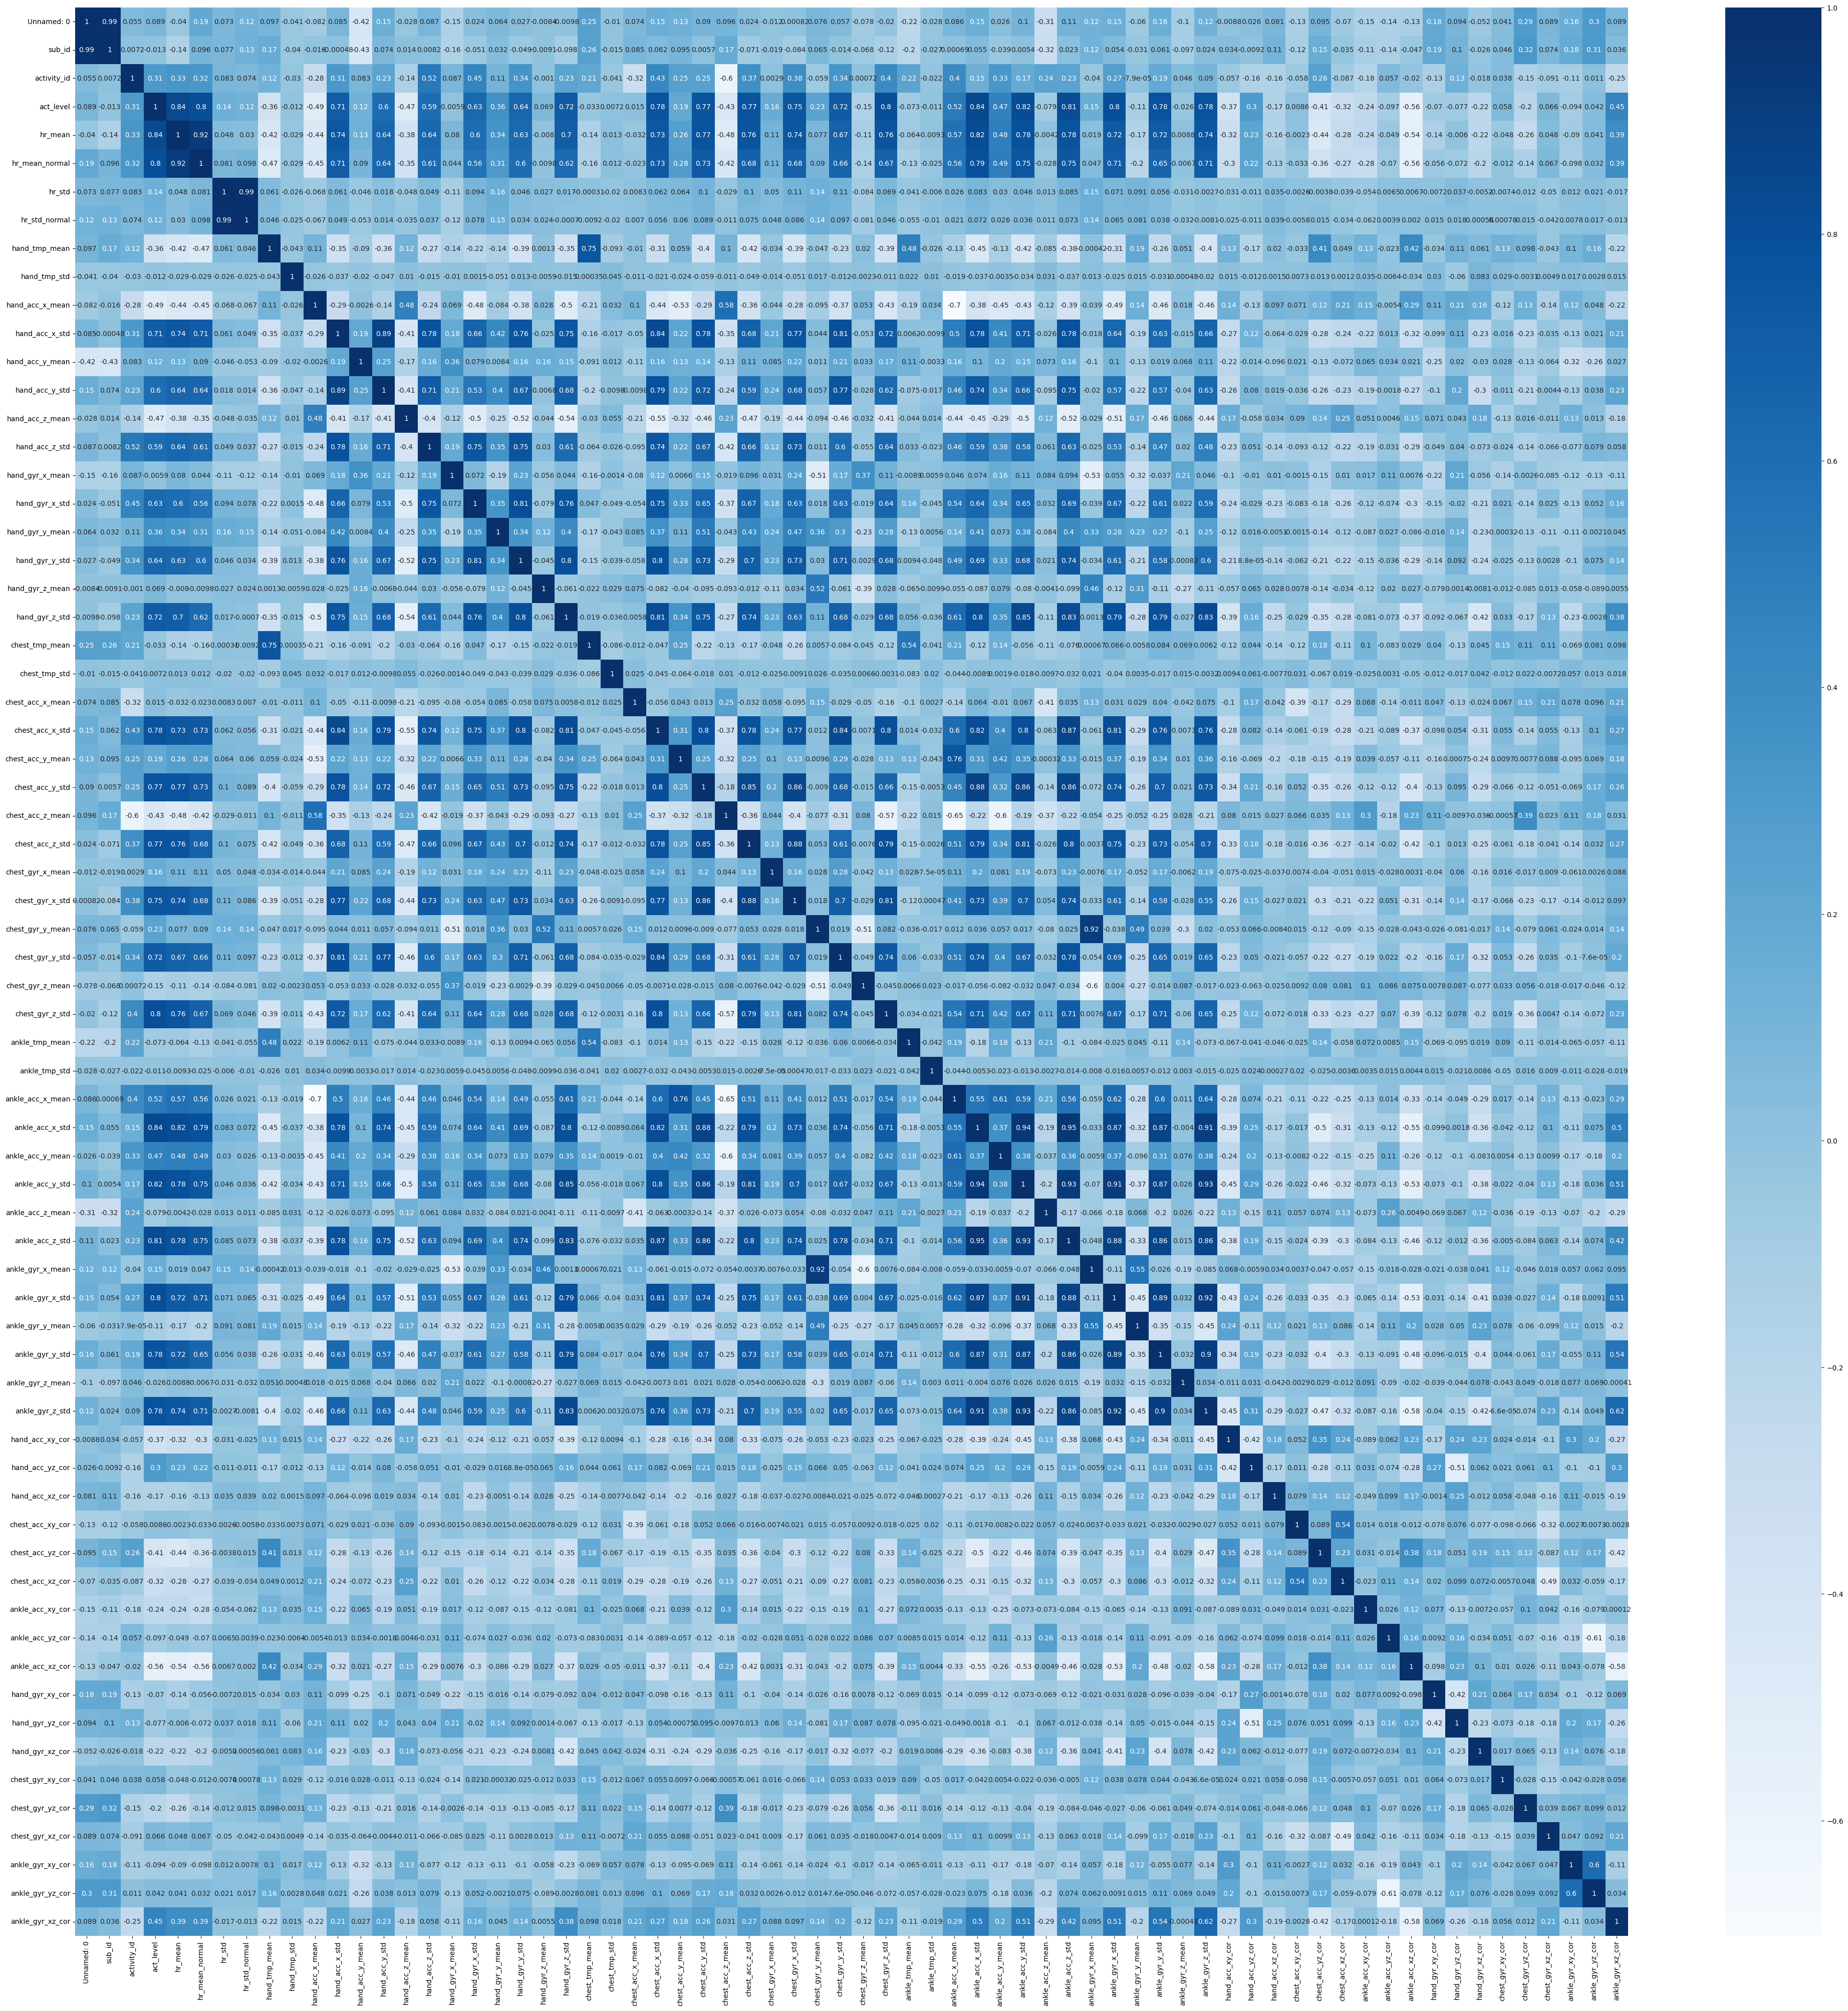

In [74]:
# heatmap visulization

plt.figure(figsize=(50, 50))

df_corr = df.corr()
sns.heatmap(df_corr, annot=True, cbar=True,
           cmap='Blues', annot_kws={"size": 10})
plt.show()

In [75]:
# 필요없는 열 제거

df = df.drop(['Unnamed: 0',
              'sub_id',
              'act_level',
              'hr_mean',
              'hr_mean_normal',
              'hr_std',
              'hr_std_normal'], axis = 1)

# PAMAP_input = df.drop(['activity_id'], axis = 1) 
# PAMAP_target = df['activity_id'] # activity_id를 예측하는 문제

# print (PAMAP_input.shape, PAMAP_target.shape)

In [76]:
# target에 포함된 요소들 확인하기

print (df['activity_id'].unique())


'''
    label이 0-based가 아니기 때문에 0-based로 바꾸어야 할 듯 하다.
    (labelencoding)
'''

[10  3  4  2  5  1  6  9  7  0  8 11]


'\n    label이 0-based가 아니기 때문에 0-based로 바꾸어야 할 듯 하다.\n    (labelencoding)\n'

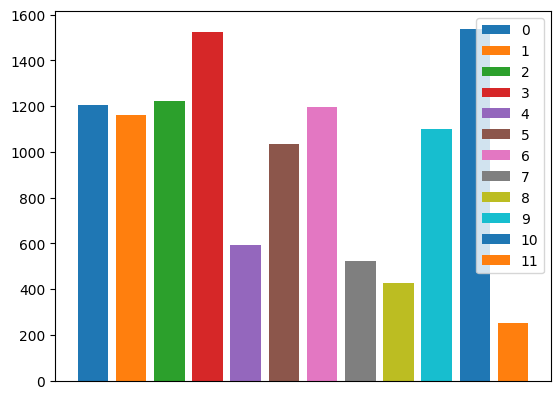

activity_id
10    1539
3     1525
2     1220
0     1203
6     1196
1     1162
9     1099
5     1035
4      593
7      522
8      428
11     251
Name: count, dtype: int64


In [77]:
# activity_id의 countplot, value_count

import math

target = np.unique(df['activity_id'])

# 시각화 진행

width = 1
for compo in target : 
    plt.bar(width, len(df[df['activity_id'] == compo]), 
            label=compo)
    width += 1
    
plt.xticks([], [])

plt.legend()
plt.show()

print (df['activity_id'].value_counts())

In [78]:

'''
    oversampling과 undersampling을 함수로 구현한다. 
'''
    
def sampling(df, target_col, max_size) :
    # 결과를 저장할 리스트 
    dfs = []
    
    for label in df[target_col].unique() :
        class_df = df[df[target_col] == label]
        
        if len(class_df) < max_size :
            # 샘플 수가 max_size보다 적으면 데이터를 복제하여 max_size로 만듦
            sampled_df = class_df.sample(max_size, replace=True, random_state=42)
        else :
            # 샘플 수가 max_size보다 많으면 앞부분부터 max_size만큼 선택함
            sampled_df = class_df.head(max_size)
        
        # 리스트에 추가
        dfs.append(sampled_df)
    
    df_resampled = pd.concat(dfs).reset_index(drop=True)
    
    return df_resampled

df_resampled = sampling(df, 'activity_id', max_size=5000)
print (df_resampled['activity_id'].value_counts())

activity_id
10    5000
3     5000
4     5000
2     5000
5     5000
1     5000
6     5000
9     5000
7     5000
0     5000
8     5000
11    5000
Name: count, dtype: int64


In [79]:
# Z-score normalization을 진행한다.

from sklearn.preprocessing import StandardScaler

X = df_resampled[[feature_name for feature_name in df_resampled.columns if feature_name != 'activity_id']]
y = df_resampled['activity_id']

SS = StandardScaler()
X = SS.fit_transform(X)

scaled_df = pd.DataFrame(data=X, 
                        columns = [feature_name for feature_name in df.columns if feature_name != 'activity_id'])
scaled_df['activity_id'] = y

scaled_df 

hand_tmp_mean  hand_tmp_std  ...  ankle_gyr_xz_cor  activity_id
0           0.527898     -0.853221  ...          0.422379           10
1           0.940570      1.182312  ...         -0.559575           10
2           0.777537     -0.853221  ...         -1.607795           10
3           0.153440     -0.853221  ...         -0.930112           10
4           0.559103     -0.853221  ...         -1.797672           10
...              ...           ...  ...               ...          ...
59995      -1.157164     -0.853221  ...         -1.934288           11
59996       0.654424      0.255789  ...         -1.180983           11
59997      -1.157164     -0.853221  ...         -1.088837           11
59998      -1.157164     -0.853221  ...         -1.456302           11
59999      -3.715962     -0.853221  ...         -0.278564           11

[60000 rows x 61 columns]

In [80]:
# input, target split

input_PAMAP = df_resampled.drop('activity_id', axis=1)
target_PAMAP = df_resampled['activity_id']

input_PAMAP.shape, target_PAMAP.shape

((60000, 60), (60000,))

In [81]:
# train, test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(input_PAMAP,
                                                    target_PAMAP,
                                                    stratify=target_PAMAP,
                                                    test_size = 0.2, shuffle=True) 

# X_train, X_val, y_train, y_val = train_test_split(X_train,
#                                                     y_train,
#                                                     stratify=y_train,
#                                                     test_size = 0.2, shuffle=True) 

X_train.shape, X_test.shape

((48000, 60), (12000, 60))

In [82]:
# train, test reshape
# DataFrame을 NumPy 배열로 변환한 후 reshape
X_train = X_train.values.reshape(-1, 20, 3)
X_test = X_test.values.reshape(-1, 20, 3)

In [83]:
# one-hot encoding 

from tensorflow.keras.utils import to_categorical

y_train_encoded = to_categorical(y_train, num_classes=12)
y_test_encoded = to_categorical(y_test, num_classes=12)

print(y_train[:5])  
print(y_train_encoded[:5]) 

print(y_test[:5])  
print(y_test_encoded[:5])

# print(y_val_seq[:5])  
# print(y_val_seq_encoded[:5])

14268    4
44917    7
49111    0
24241    5
20371    5
Name: activity_id, dtype: int64
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
11641    4
33107    6
17049    2
48140    0
30840    6
Name: activity_id, dtype: int64
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


-----

In [84]:
import keras
from keras.layers import Input, Conv1D, BatchNormalization, ReLU, Add, GlobalAveragePooling1D, Dense
from keras.models import Model

In [85]:
def residual_block(x, filters):
    shortcut = x
    x = Conv1D(filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv1D(filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    
    # Shortcut connection
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

In [86]:

def create_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Initial Conv Layer
    x = Conv1D(64, kernel_size=7, padding='same', strides=2)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # Residual Blocks
    for _ in range(3) :  # Adjust the number of blocks as needed
        x = residual_block(x, 64)
    
    # Global Average Pooling and Output Layer
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 20, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 10, 64)    │      1,408 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 64)    │        256 │ conv1d_28[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_28 (ReLU)     │ (None, 10, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 10, 64)    │     12,352 │ re_lu_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 64)    │        256 │ conv1d_29[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_29 (ReLU)     │ (None, 10, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 10, 64)    │     12,352 │ re_lu_29[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 64)    │        256 │ conv1d_30[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 10, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ re_lu_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_30 (ReLU)     │ (None, 10, 64)    │          0 │ add_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 10, 64)    │     12,352 │ re_lu_30[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 64)    │        256 │ conv1d_31[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_31 (ReLU)     │ (None, 10, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 10, 64)    │     12,352 │ re_lu_31[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 64)    │        256 │ conv1d_32[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 10, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ re_lu_30[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_32 (ReLU)     │ (None, 10, 64)    │          0 │ add_13[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 10, 64)    │     12,352 │ re_lu_32[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 64)    │        256 │ conv1d_33[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 78,092 (305.05 KB)

 Trainable params: 77,196 (301.55 KB)

 Non-trainable params: 896 (3.50 KB)

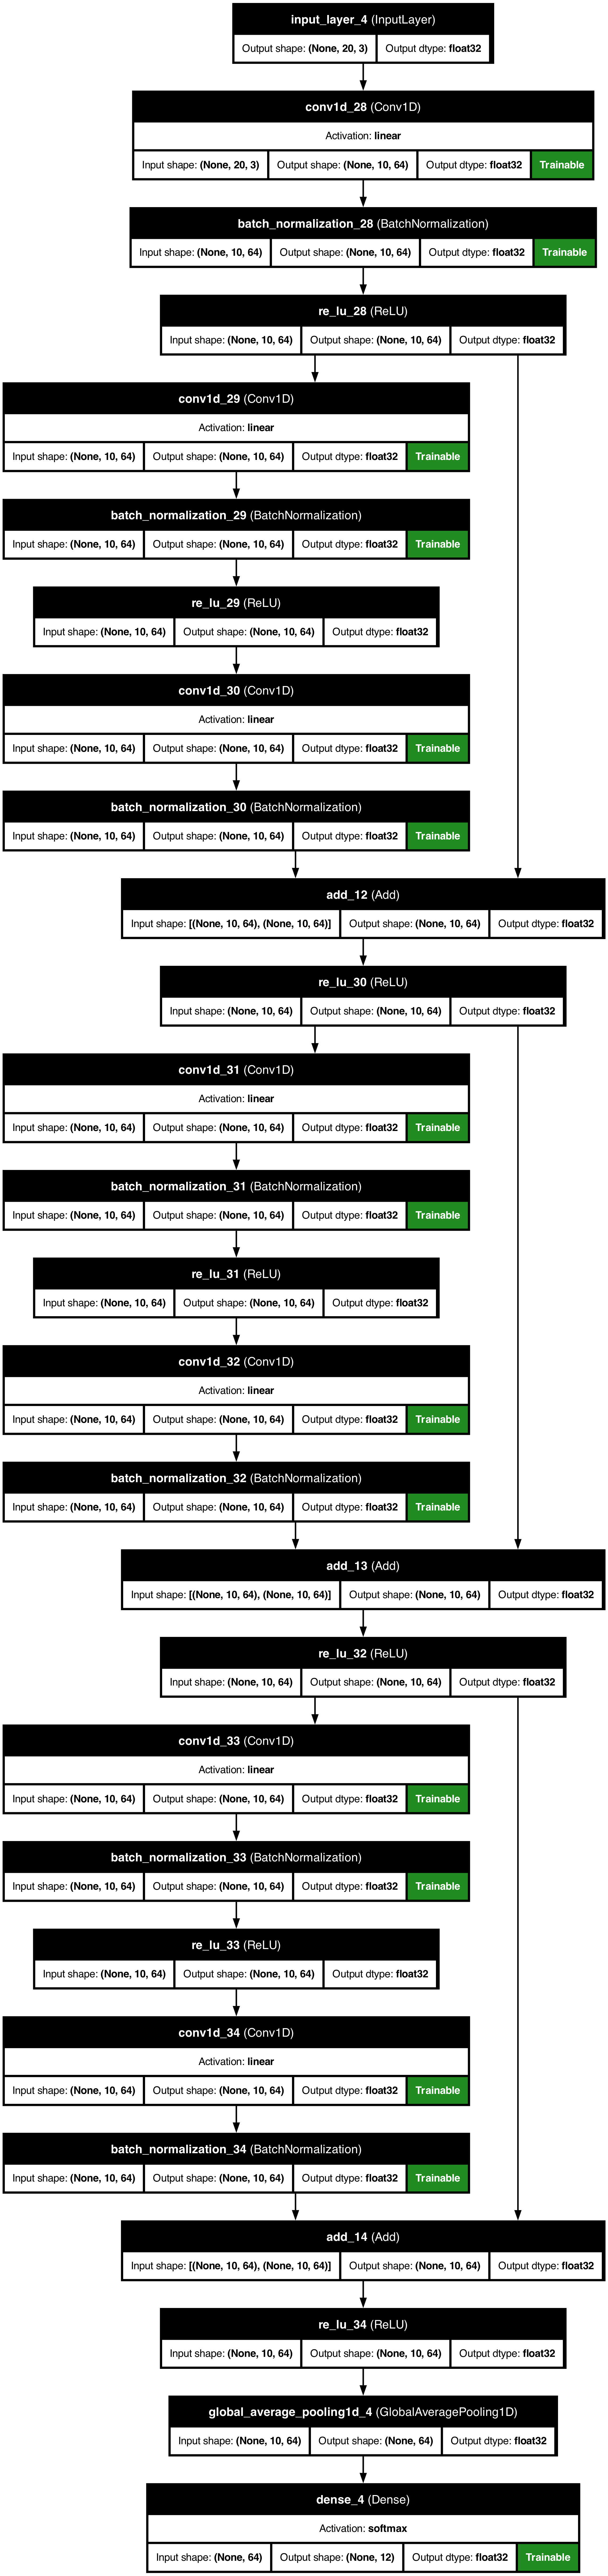

In [87]:
# modeling

ResNet = create_resnet(input_shape=(X_train.shape[1], X_train.shape[2]),
                      num_classes=12)

ResNet.summary()
tf.keras.utils.plot_model(ResNet, show_dtype=True,
                         show_layer_activations=True,
                         show_layer_names=True,
                         show_shapes=True,
                         show_trainable=True)

In [88]:
# compile

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
ResNet.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])  # 각 출력에 대한 metric 설정

In [89]:
# fit

from memory_profiler import profile

@profile  # 메모리 오버플로우로 인한 시스템 다운을 막기 위해서
def train_model(model, X, y):
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

    history = model.fit(X_train, y_train_encoded, epochs=10, 
                    validation_split=0.2, batch_size=128, callbacks=[early_stopping_cb], 
                    verbose=True, shuffle=True)

    
    return history

history = train_model(ResNet, X_train, y_train_encoded)


ERROR: Could not find file /var/folders/_z/gryfr07n59jgb3wrd062h1ym0000gn/T/ipykernel_71530/2249351200.py
Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5315 - loss: 1.7252 - val_accuracy: 0.9592 - val_loss: 0.5042
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.9732 - loss: 0.1555 - val_accuracy: 0.9809 - val_loss: 0.0910
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.9854 - loss: 0.0736 - val_accuracy: 0.9918 - val_loss: 0.0511
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9917 - loss: 0.0446 - val_accuracy: 0.9847 - val_loss: 0.0587
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9942 - loss: 0.0316 - val_accuracy: 0.9950 - val_loss: 0.0261
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.9968 - loss: 0.0210 - val_accuracy: 0.9970 - val_loss: 0.0169
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.9968 - loss: 0.0178 - val_accuracy: 0.9990 - val_los

{'accuracy': [0.7864583134651184, 0.9768489599227905, 0.987708330154419, 0.9922916889190674, 0.9949739575386047, 0.9970052242279053, 0.9974479079246521, 0.9985416531562805, 0.9989323019981384, 0.9989323019981384], 'loss': [0.9014660716056824, 0.12717469036579132, 0.06489673256874084, 0.04116496443748474, 0.02780281938612461, 0.019184641540050507, 0.016738081350922585, 0.011420181952416897, 0.009762637317180634, 0.00817720778286457], 'val_accuracy': [0.9591666460037231, 0.9809374809265137, 0.9917708039283752, 0.9846875071525574, 0.9950000047683716, 0.9969791769981384, 0.9989583492279053, 0.9984375238418579, 0.9986458420753479, 1.0], 'val_loss': [0.504223108291626, 0.09103789180517197, 0.05113295093178749, 0.0586671307682991, 0.026124797761440277, 0.016850505024194717, 0.011923475190997124, 0.010009384714066982, 0.006698709446936846, 0.005301884841173887]}


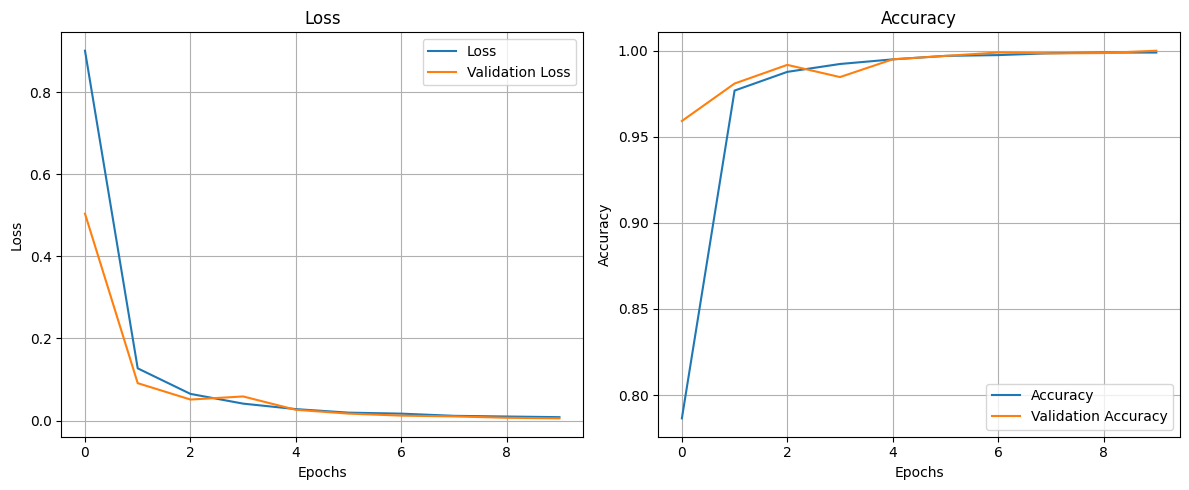

In [90]:
# loss와 validation loss, acc와 validation acc를 시각화하기 위한 메소드

print (history.history)

def draw_history (history) :
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].plot(history.history['loss'], label='Loss')
    ax[0].plot(history.history['val_loss'], label='Validation Loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(history.history['accuracy'], label='Accuracy')
    ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    ax[1].grid()

    plt.tight_layout()
    plt.show()

draw_history(history)

In [ ]:
# confusion matrix, classification report, accuracy

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

y_test_arg = np.argmax(y_test_encoded, axis=1)
Y_pred = np.argmax(ResNet.predict(X_test) ,axis=1)
print ('Confusion Matrix')
cm = confusion_matrix(y_test_arg, Y_pred)

# confusion matrix 시각화
plt.figure(figsize=(8, 6))  # 그래프 크기 조절 (너비 8, 높이 6)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

# classification report
report = classification_report(y_test_arg, Y_pred)
print (report)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
# evaulate

print ("train score : ", ResNet.evaluate(X_train, y_train_encoded))
print ("test score : ", ResNet.evaluate(X_test, y_test_encoded))

eval = ResNet.evaluate(X_test, y_test_encoded)

print(eval)

In [ ]:
# 모델 저장

from tensorflow.keras.models import save_model

def save_trained_model(model, model_name, dataset_name) :
    # 모델 저장 경로 설정
    model_dir = './model'
    os.makedirs(model_dir, exist_ok=True)
    
    # 모델 파일 경로
    model_name = f"{model_name}_{dataset_name}.h5"  # 모델 이름과 데이터셋 이름 조합
    model_path = os.path.join(model_dir, model_name)
    
    # 모델 저장
    save_model(model, model_path)
    print(f'Model saved at {model_path}')

save_trained_model(ResNet, "ResNet", "PAMAP")